In [1]:
from pandas import read_csv, unique

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.interpolate import interp1d
from numpy import dstack
from scipy.stats import mode

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from keras.layers import Conv1D, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
features_df = pd.read_csv("/content/drive/MyDrive/Data/UCI HAR Dataset/features.txt",
                          sep="\s+", header=None, names=["column_index", "column_name"])

In [4]:
feature_names = features_df["column_name"].values.tolist()

In [5]:
import pandas as pd

# 파일 경로 설정
path = "/content/drive/MyDrive/Data/UCI HAR Dataset/"

# 특징 파일 불러오기
X_train = pd.read_csv(path+"train/X_train.txt", sep="\s+", header=None)
X_test = pd.read_csv(path+"test/X_test.txt", sep="\s+", header=None)

# 각 특징에 대한 열 이름 추가
X_train.columns = feature_names
X_test.columns = feature_names

# X_train과 X_test를 데이터프레임으로 만들어주기
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)


In [6]:
# 레이블 파일 불러오기
y_train = pd.read_csv(path+"train/y_train.txt", sep="\s+", header=None, names=["activity"])
y_test = pd.read_csv(path+"test/y_test.txt", sep="\s+", header=None, names=["activity"])

# 클래스 레이블을 0부터 시작하도록 조정
y_train = y_train - 1
y_test = y_test - 1

In [7]:
# 훈련 데이터 생성
train_data = pd.concat([X_train, y_train], axis=1)

# 테스트 데이터 생성
test_data = pd.concat([X_test, y_test], axis=1)

In [8]:
train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,4
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,4
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,4
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,4
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,4


In [9]:
len(train_data)

7352

In [10]:
train_data['activity'].value_counts()

5    1407
4    1374
3    1286
0    1226
1    1073
2     986
Name: activity, dtype: int64

In [11]:
label_encode = LabelEncoder()
train_data['activity'] = label_encode.fit_transform(train_data['activity'].values.ravel())

In [12]:
train_data.isna().sum()

tBodyAcc-mean()-X                       0
tBodyAcc-mean()-Y                       0
tBodyAcc-mean()-Z                       0
tBodyAcc-std()-X                        0
tBodyAcc-std()-Y                        0
                                       ..
angle(tBodyGyroJerkMean,gravityMean)    0
angle(X,gravityMean)                    0
angle(Y,gravityMean)                    0
angle(Z,gravityMean)                    0
activity                                0
Length: 562, dtype: int64

In [13]:
print(len(test_data))
test_data.head()

2947


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",activity
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,-0.330370,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,4
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.121845,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,4
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.190422,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,4
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.344418,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,4
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.534685,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,4


In [14]:
# x_train = train_data.drop(['activity'], axis=1)
# y_train = train_data['activity']
# x_test = test_data.drop(['activity'], axis=1)
# y_test = test_data['activity']
# Scale train/ test predictors based on training data
scaler = StandardScaler().fit(train_data)
x_train = scaler.transform(train_data)
x_test = scaler.transform(test_data)

In [15]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7352, 562), (7352, 1), (2947, 562), (2947, 1))

In [16]:
def segments(df, time_steps, step):
    N_FEATURES = 3
    segments = []
    labels = []

    # Assuming the last column is the label (activity)
    label_name = df.columns[-1]

    for i in range(0, len(df) - time_steps, step):
        xs = df['tBodyAcc-mean()-X'].values[i:i+time_steps]
        ys = df['tBodyAcc-mean()-Y'].values[i:i+time_steps]
        zs = df['tBodyAcc-mean()-Z'].values[i:i+time_steps]

        label = mode(df[label_name][i:i+time_steps])[0]

        segments.append([xs, ys, zs])  # Transpose to get [X, Y, Z]
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels


In [27]:
TIME_PERIOD = 10
STEP_DISTANCE = 10
LABEL = 'activity'
x_train, y_train = segments(train_data, TIME_PERIOD, STEP_DISTANCE)

In [28]:
print('x_train shape:', x_train.shape)
print('Training samples:', x_train.shape[0])
print('y_train shape:', y_train.shape)

x_train shape: (735, 10, 3)
Training samples: 735
y_train shape: (735,)


In [29]:
time_period, sensors = x_train.shape[1], x_train.shape[2]
num_classes = label_encode.classes_.size
print(list(label_encode.classes_))

[0, 1, 2, 3, 4, 5]


In [30]:
## reshaping data
input_shape = time_period * sensors
x_train = x_train.reshape(x_train.shape[0], input_shape)
print("Input Shape: ", input_shape)
print("Input Data Shape: ", x_train.shape)

Input Shape:  30
Input Data Shape:  (735, 30)


In [31]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [32]:
y_train_hot = to_categorical(y_train, num_classes)
print("y_train shape: ", y_train_hot.shape)

y_train shape:  (735, 6)


In [36]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(input_shape,1), activation='relu'))
model.add(LSTM(32,return_sequences=True, activation='relu'))
model.add(Reshape((1, 30, 32)))
model.add(Conv1D(filters=64,kernel_size=2, activation='relu', strides=2))
model.add(Reshape((15, 64)))
model.add(MaxPool1D(pool_size=4, padding='same'))
model.add(Conv1D(filters=192, kernel_size=2, activation='relu', strides=1))
model.add(Reshape((3, 192)))
model.add(GlobalAveragePooling1D())
model.add(BatchNormalization(epsilon=1e-06))
model.add(Dense(6))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 32)            4352      
                                                                 
 lstm_7 (LSTM)               (None, 30, 32)            8320      
                                                                 
 reshape_6 (Reshape)         (None, 1, 30, 32)         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 15, 64)         4160      
                                                                 
 reshape_7 (Reshape)         (None, 15, 64)            0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 4, 64)             0         
 g1D)                                                            
                                                      

In [37]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train,
                    y_train_hot,
                    batch_size= 192,
                    epochs=100
                   )

Epoch 1/100
4/4 [==============================] - 7s 50ms/step - loss: 1.7703 - accuracy: 0.2803
Epoch 2/100
4/4 [==============================] - 0s 54ms/step - loss: 1.6931 - accuracy: 0.3293
Epoch 3/100
4/4 [==============================] - 0s 50ms/step - loss: 1.6524 - accuracy: 0.3320
Epoch 4/100
4/4 [==============================] - 0s 58ms/step - loss: 1.6085 - accuracy: 0.3361
Epoch 5/100
4/4 [==============================] - 0s 54ms/step - loss: 1.5593 - accuracy: 0.3456
Epoch 6/100
4/4 [==============================] - 0s 49ms/step - loss: 1.5092 - accuracy: 0.3728
Epoch 7/100
4/4 [==============================] - 0s 49ms/step - loss: 1.4458 - accuracy: 0.3878
Epoch 8/100
4/4 [==============================] - 0s 52ms/step - loss: 1.3709 - accuracy: 0.4245
Epoch 9/100
4/4 [==============================] - 0s 59ms/step - loss: 1.2821 - accuracy: 0.4925
Epoch 10/100
4/4 [==============================] - 0s 49ms/step - loss: 1.2315 - accuracy: 0.5048
Epoch 11/100
4/4 [=

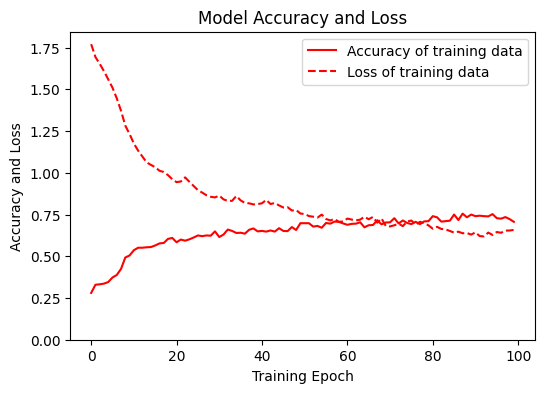

23/23 [==============================] - 2s 23ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       133
         1.0       0.00      0.00      0.00       113
         2.0       0.00      0.00      0.00        87
         3.0       0.00      0.00      0.00       135
         4.0       0.00      0.00      0.00       132
         5.0       0.18      1.00      0.31       135

    accuracy                           0.18       735
   macro avg       0.03      0.17      0.05       735
weighted avg       0.03      0.18      0.06       735



In [38]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

y_pred_train = model.predict(x_train)
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

In [40]:
x_test, y_test = segments(test_data,
                         TIME_PERIOD,
                         STEP_DISTANCE)

x_test = x_test.reshape(x_test.shape[0], input_shape)
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
y_test = to_categorical(y_test, num_classes)

In [41]:
score = model.evaluate(x_test, y_test)
print("Accuracy:", score[1])
print("Loss:", score[0])

10/10 [==============================] - 1s 9ms/step - loss: 1.9775 - accuracy: 0.1735
Accuracy: 0.1734693944454193
Loss: 1.9774842262268066


10/10 [==============================] - 0s 10ms/step


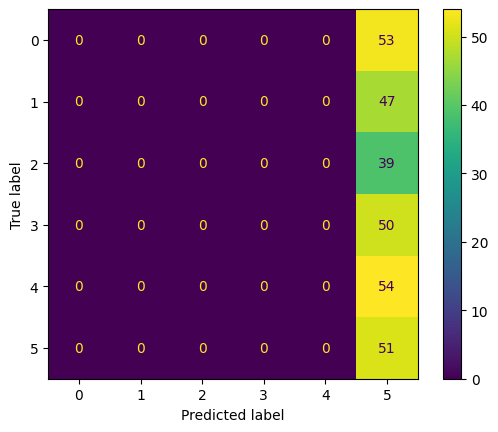

In [42]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
y_test_pred = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_pred, predictions)
cm_disp = ConfusionMatrixDisplay(confusion_matrix= cm)
cm_disp.plot()
plt.show()

In [43]:
print(classification_report(y_test_pred, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.00      0.00      0.00        47
           2       0.00      0.00      0.00        39
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        54
           5       0.17      1.00      0.30        51

    accuracy                           0.17       294
   macro avg       0.03      0.17      0.05       294
weighted avg       0.03      0.17      0.05       294



In [44]:
from keras.models import load_model

# 모델 저장
model.save('LSTM-CNN2.h5')  # 모델을 'my_model.h5' 파일로 저장
